### Description
Basic example of MODFLOW 6 groundwater flow modeling with Flopy. The model is multilayered and runs on transient conditions with the recharge, well and river boundary conditions implemented. The example also load model results and create head distributions with flow direction plots with Matplotlib.

Basic example of MODFLOW 6 groundwater flow modeling coupled with MODPATH 7 particle tracking with Flopy. The model is multilayered and runs on transient conditions with the recharge, well and river boundary conditions implemented. The example define the package inputs and implement the packages afterwards. 

In [1]:
# Clone the repository
!git clone https://github.com/hatarilabs/introductionMF6modelingPythonFlopyGoogleColab.git

# Make the mf6 file executable
!chmod +x /content/introductionMF6modelingPythonFlopyGoogleColab/bin/mf6

# To avoid some Google Colab unconvenients
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [ ]:
#install flopy
#!pip install flopy
#import required packages
import sys, os
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy


###  Define mf6 simulation

In [2]:
# model info
modelName = 'exampleModel'
# modelWs = 'modelFiles' #use particular names
# mf6Exe = 'bin/mf6.exe'
modelWs = '/content/introductionMF6modelingPythonFlopyGoogleColab/modelFiles' #use particular names
mf6Exe = '/content/introductionMF6modelingPythonFlopyGoogleColab/bin/mf6'

# create simulation
sim = flopy.mf6.MFSimulation(sim_name=modelName, version='mf6', exe_name=mf6Exe,
                             sim_ws=modelWs)

# create temporal discretization package
tdisPeriodData = [(1000.0, 1, 1.0)]
tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             perioddata=tdisPeriodData)

### Define gwf model and internal packages

In [3]:
# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, 
                           modelname=modelName,
                           save_flows=True)

In [4]:
# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim,  
                           outer_dvclose=1.e-5, 
                           outer_maximum=100,
                           linear_acceleration='BICGSTAB')
sim.register_ims_package(ims,[modelName])

In [5]:
# define storage and transient stress periods
sto = flopy.mf6.ModflowGwfsto(gwf, 
                              ss=1e-05,
                              sy=0.15,
                              steady_state=[True,False,False])

In [6]:
# spatial discretization - dis package
nlay = 3
nrow = 21
ncol = 20
delr = 500.
delc = 500.
top = 400.
botm = [220., 200., 0.]

dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm)

In [7]:
# initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, pname='ic', strt=320.)

In [8]:
# define node property flow with hydraulic properties
hkLayer = [50.0, 0.01, 200.0]
vkLayer = [10., 0.01, 20.]
npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=[('xt3d')],
                              save_specific_discharge=True,
                              icelltype=[1,0,0], 
                              k=hkLayer,
                              k33=vkLayer)

### Define boundary conditions

[<Axes: title={'center': ' wel_0 location stress period 1 layer 3'}>]

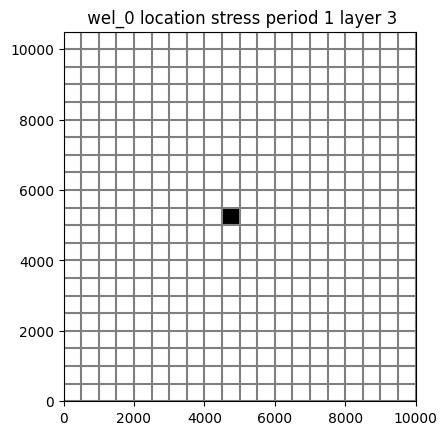

In [9]:
# well boundary condition
welSpd = [[(2, 10, 9), -1.5e5]]

wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=welSpd)

wel.plot(mflay=2, grid=True)


In [10]:
# recharge boundary condition

rechValue = 0.005 # in meters / day

rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rechValue)

[<Axes: title={'center': ' riv_0 location stress period 1 layer 1'}>]

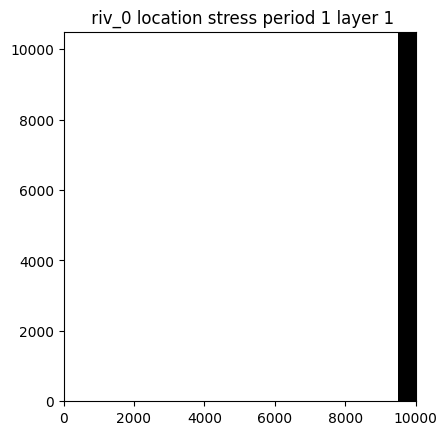

In [11]:
# river boundary conditions for all cells in the last column
rivSpd = [[(0, i, ncol-1), 320., 1.e5, 318.] for i in range(nrow)]

riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivSpd)

riv.plot(mflay=0)

In [12]:
### Define output control and run simulation

# output control
oc = flopy.mf6.ModflowGwfoc(gwf, pname='oc', 
                            budget_filerecord= modelName + '.cbc',
                            head_filerecord= modelName + '.hds',
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [13]:
#write and run simulation
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model exampleModel...
    writing model name file...
    writing package sto...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package rcha_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/20/2024

   MODFLOW 6 compiled Dec 31 2024 17:08:41 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version

(True, [])

### Import model data and head representation

In [27]:
# load the heads and budget files
fname = os.path.join(modelWs, modelName + '.hds')
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()

fname = os.path.join(modelWs, modelName + '.cbc')
cbb = flopy.utils.CellBudgetFile(fname, precision='double')
spdis = cbb.get_data(text='DATA-SPDIS')[0]
qx = spdis['qx'].reshape(nlay, nrow, ncol)
qy = spdis['qy'].reshape(nlay, nrow, ncol)
qz = spdis['qz'].reshape(nlay, nrow, ncol)

320

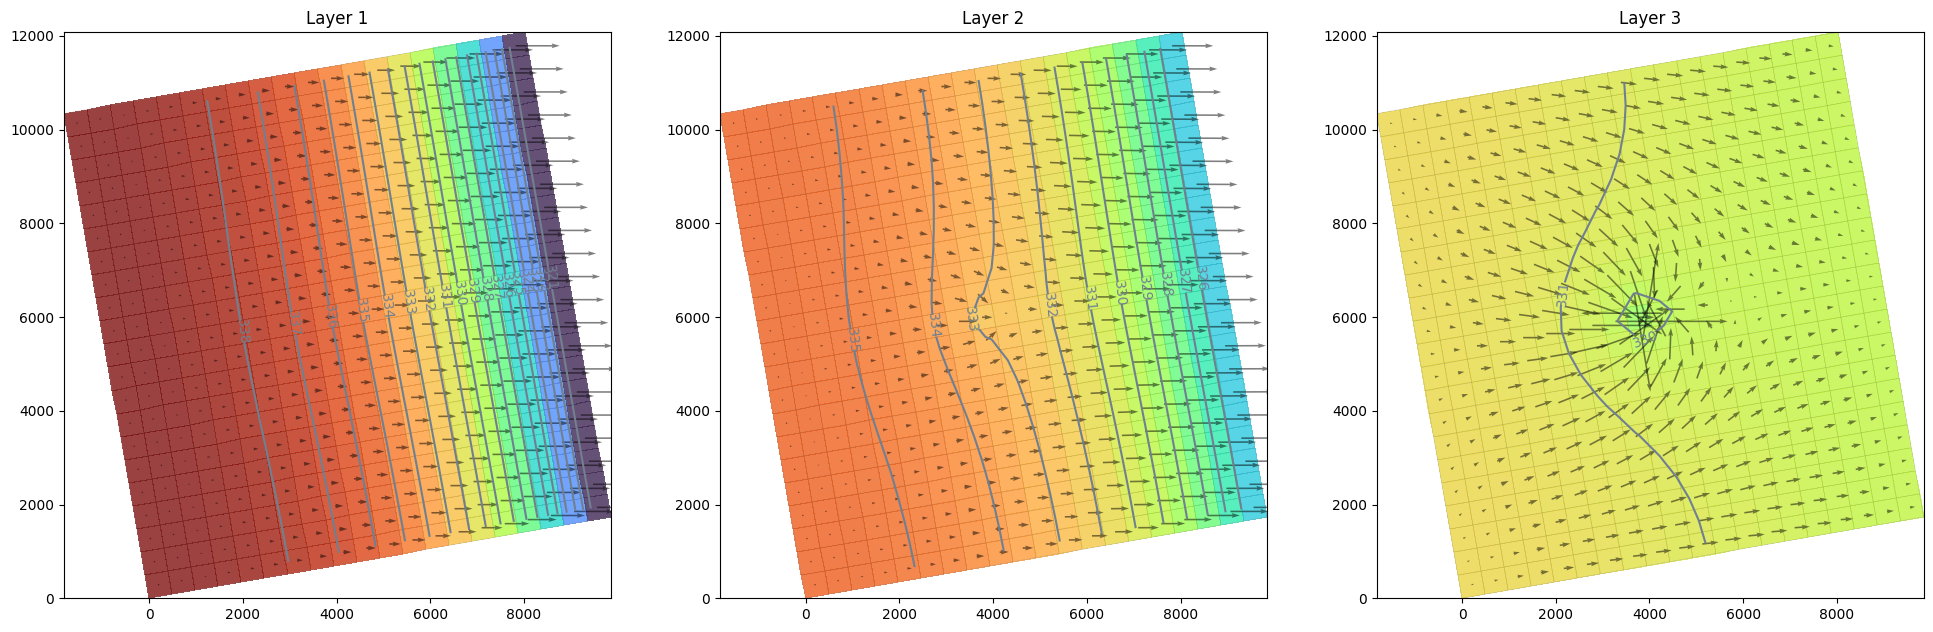

In [35]:
# plot the results for each layer
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,12))

#for contour levels
vmin = int(head.min())
vmax = int(head.max())
#levels = np.linspace(vmin, vmax, 20)
levels = np.arange(vmin,vmax,1)

#give rotation and extract grid center array
gwf.modelgrid.set_coord_info(angrot=10.)
xcentergrid = gwf.modelgrid.xcellcenters
ycentergrid = gwf.modelgrid.ycellcenters


for ilay in range(nlay):
    ax = axes[ilay]
    ax.set_title('Layer {}'.format(ilay + 1))
    ax.set_aspect('equal')
    modelmap = flopy.plot.PlotMapView(model=gwf, layer=ilay, ax=ax)
    quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5, 
                                   vmin=vmin, vmax=vmax, cmap='turbo')
    linecollection = modelmap.plot_grid(alpha=0.5, lw=0.3)
    contour = modelmap.contour_array(head, levels=levels, colors='slategrey')

    # Add labels to the contours
    ax.clabel(contour, fmt="%d", fontsize=10)
    
    #flow directions 
    quiver = ax.quiver(xcentergrid, ycentergrid, qx[ilay], qy[ilay], alpha=0.5)